# dysh demo   
-----------
## (CAVEAT:   a few features added after 0.3.0 are used here)
July 11, 2024:     merge "main" into the "get_dysh" branch for this to work as intended

## General

The richness of the Python ecosystem allows for several ways to run python code. Here are three common ones we've used with **dysh**:

1. Jupyter Labs/**Notebooks** (this demo)
2. **dysh**: an ipython based CLI, with predefined settings to make working with dysh easy. Close to the GBTIDL experience
3. Introspective GUI environments, such as **spyder**. Can be useful for some developers


## Calibrating and Smoothing a Position Switched (PS) observation

This notebook shows how to use `dysh` to calibrate and smooth a PS observation.   For the example below we will use data from the Position-Switch example. The following dysh commands are the simplest to get and smooth a spectrum (leaving out all the function arguments):

      sdf = GBTFITSLoad()          # load an SDFITS file
      sb = sdf.getps()             # get a PS observation into one or more ScanBlocks
      ta = sb.timeaverage()        # timeaverage all ScanBlocks, where allowed!
      tb = ta.smooth()             # smooth (and decimate) the spectrum 
      tb.plot()                    # plot the spectrum                    

or if you wish to make use of the Python object chaining:

       GBTFITSLoad().getps().timeaverage().smooth().plot()
      

### First load the modules we're going to need

In [1]:
import numpy as np
import astropy.units as u
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.util.files import dysh_data

### Define "rolled_stats", a helper function

In [2]:
# show the mean and std for data and for a 1-rolled data
def rolled_stats(data, label='stats:'):
    delta = data[1:] - data[:-1]
    print(label,data.mean(), data.std(), delta.mean(), delta.std(), delta.std()/data.std()/np.sqrt(2))

# to test, check that rolled_stats has a sqrt(2) higher RMS
np.random.seed(123)
rolled_stats(np.random.normal(0,1,10000))

stats: 0.009711892291595955 0.9981138545901473 0.00020564491109648523 1.4025754219952096 0.9936447505035827


## Single Dish Math

The hot/sky calibration returns a system temperature (a scalar):
$$
 T_{sys} = T_{cal} { { <SKY> } \over { <HOT - SKY> } } + T_{cal}/2
$$
where the averaging operator avoids the edges of the passbaand.  


After this a comparison between the ON and OFF gives the astronomical signal:
$$
  T_A = T_{sys}  {   { ON - OFF } \over {OFF} }
$$

## Load the Position-Switch SDFITS file example

The ``dysh_data()`` function can use ``example=`` or ``test=``, where the latter is just a very short example that is included with the github source. For any real work (as in this demo) we use the longer example= version which has 151 integrations, and then some.


In [3]:
filename = dysh_data(example='getps')      # CAVEAT: new feature
print(filename)

TGBT21A_501_11.raw.vegas.fits already downloaded
TGBT21A_501_11.raw.vegas.fits


In [4]:
!ls -l

total 785356
-rw-rw-r-- 1 teuben teuben     24828 Jun 27 22:58 baselined_removed.png
-rw-rw-r-- 1 teuben teuben    117405 Jul 11 09:22 dataIO.ipynb
-rw-rw-r-- 1 teuben teuben    424811 Jul 11 09:07 frequencyswitch.ipynb
-rw-rw-r-- 1 teuben teuben   1721582 Jul 11 09:36 ngc2415.ecsv
-rw-rw-r-- 1 teuben teuben   1589760 Jul 11 09:36 ngc2415.fits
-rw-rw-r-- 1 teuben teuben   1719158 Jul 11 09:36 ngc2415.txt
-rw-rw-r-- 1 teuben teuben    435703 Jul 10 16:14 onoff-L_getps_152_RADI-HEL.ascii.gz
-rw-rw-r-- 1 teuben teuben   1343617 Jul 10 16:14 onoff-L_gettp_156_intnum_0_HEL.ascii
-rw-rw-r-- 1 teuben teuben    236879 Jul 10 21:33 positionswitch.ipynb
-rw-rw-r-- 1 teuben teuben    283854 Jul 10 21:25 smoothing.ipynb
-rw-rw-r-- 1 teuben teuben      2463 Jun 28 08:26 smoothing.py
-rw-rw-r-- 1 teuben teuben    355149 Jul 11 09:43 stakeholders-demo.ipynb
-rw-rw-r-- 1 teuben teuben    244746 Jul 10 16:13 subbeamnod.ipynb
-rw-rw-r-- 1 teuben teuben 795479040 Jul 10 22:01 TGBT21A_501_11.raw.vegas.fit

In [5]:
sdfits = GBTFITSLoad(filename)
sdfits.summary(verbose=False)

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,152,NGC2415,3784.0,OnOff,1,1.617185,1.420406,5,2,151,1,286.218008,41.62843
1,153,NGC2415,3784.0,OnOff,2,1.617185,1.420406,5,2,151,1,286.886521,41.118134


In [6]:
#   use the fact that we store the SDFITS as a panda's DataFrame,  sdfits._index.keys()
sdfits._index.keys()

Index(['OBJECT', 'BANDWID', 'DATE-OBS', 'DURATION', 'EXPOSURE', 'TSYS',
       'TDIM7', 'TUNIT7', 'CTYPE1', 'CRVAL1', 'CRPIX1', 'CDELT1', 'CTYPE2',
       'CRVAL2', 'CTYPE3', 'CRVAL3', 'CRVAL4', 'OBSERVER', 'OBSID', 'SCAN',
       'OBSMODE', 'FRONTEND', 'TCAL', 'VELDEF', 'VFRAME', 'RVSYS', 'OBSFREQ',
       'LST', 'AZIMUTH', 'ELEVATIO', 'TAMBIENT', 'PRESSURE', 'HUMIDITY',
       'RESTFREQ', 'FREQRES', 'EQUINOX', 'RADESYS', 'TRGTLONG', 'TRGTLAT',
       'SAMPLER', 'FEED', 'SRFEED', 'FEEDXOFF', 'FEEDEOFF', 'SUBREF_STATE',
       'SIDEBAND', 'PROCSEQN', 'PROCSIZE', 'PROCSCAN', 'PROCTYPE', 'LASTON',
       'LASTOFF', 'TIMESTAMP', 'QD_XEL', 'QD_EL', 'QD_BAD', 'QD_METHOD',
       'VELOCITY', 'ZEROCHAN', 'DOPFREQ', 'ADCSAMPF', 'VSPDELT', 'VSPRVAL',
       'VSPRPIX', 'SIG', 'CAL', 'CALTYPE', 'TWARM', 'TCOLD', 'CALPOSITION',
       'IFNUM', 'PLNUM', 'FDNUM', 'HDU', 'BINTABLE', 'ROW', 'SIMPLE', 'EXTEND',
       'DATE', 'ORIGIN', 'TELESCOP', 'INSTRUME', 'SDFITVER', 'FITSVER',
       'CTYPE4', 'PR

In [7]:
# check one or more columns
sdfits._index[["DATE-OBS","TCAL","INTNUM","IFNUM","PLNUM","CAL"]]

,DATE-OBS,TCAL,INTNUM,IFNUM,PLNUM,CAL
0,2021-02-10T07:38:37.50,1.428060,0,0,1,F
1,2021-02-10T07:38:37.50,1.428060,0,0,1,T
2,2021-02-10T07:38:37.50,1.455164,0,0,0,F
3,2021-02-10T07:38:37.50,1.455164,0,0,0,T
4,2021-02-10T07:38:37.50,1.602189,0,1,1,F
...,...,...,...,...,...,...
6035,2021-02-10T07:48:50.97,1.470465,150,3,0,T
6036,2021-02-10T07:48:50.97,1.368713,150,4,1,F
6037,2021-02-10T07:48:50.97,1.368713,150,4,1,T
6038,2021-02-10T07:48:50.97,1.419782,150,4,0,F


## Behind the scenes: SDFITS file data storage

In this particular PS case there are 6040 rows, slowest variable listed first

1. nscans = 2 : scans 152 and 153 (the ON and OFF, or SIG and REF)
2. ntime = 151 integrations of 1" each
3. nif = 5 IF's
4. npol = 2 POL's
5. ncal = 2 : CALON/CALOFF
6. nchan = 32768 channels

The run time of this PS case is thus:   2 x 151sec x 2 ~ 10 mins   (IF and POL are simultaneous). Slewing took about 12.5 sec, looking at the DATE-OBS between rows 6020 and 6021

Thus the spectral data could be written as as 6 dimensional array

      data[nscan][ntime][nif][npol][ncal][nchan]

whereas all other columns are 5 dimensional:

      tcal[nscan][ntime][nif][npol][ncal]


### Plotting the very first RAW spectrum:

Found BUNIT=None, now finding TUNIT7=, using the latter


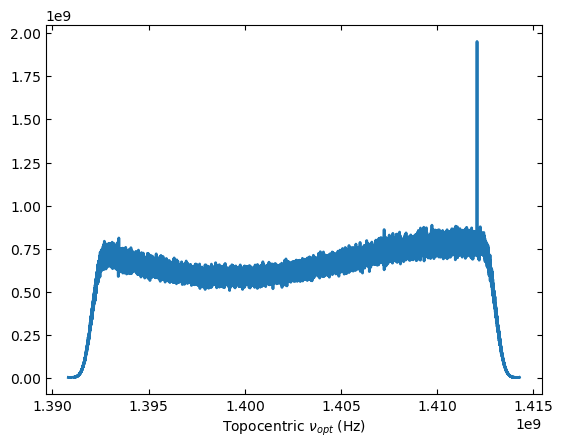

In [8]:
sp0 = sdfits.getspec(0)
sp0.plot()

## Get a time-averaged spectrum at the highest resolution

This test data has 151 integrations of 1 second, so time averaging should make things better. 



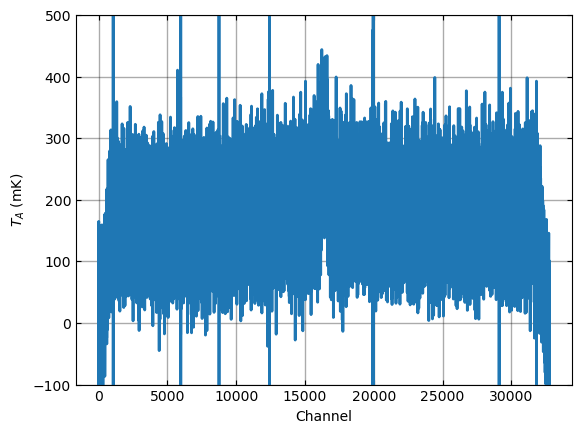

stats: 0.1802747611297031 K 0.05488477800860452 K 2.541479507945146e-05 K 0.07699206258407011 K 0.9919254759889891
expect:0.1802747611297031 K 0.05488477800860452 K (mean and std)


In [9]:
sb = sdfits.getps(scan=152, ifnum=0, plnum=0)
ta = sb.timeaverage(weights='tsys')
ta.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-100, ymax=500, grid=True)
rolled_stats(ta.flux[21000:28000])
print("expect:0.1802747611297031 K 0.05488477800860452 K (mean and std)")    # regression from previous runs

## Smooth in a few ways

By default smoothing will also decimate the signal, to (roughly) make each channel independant of the next. This assuming the input signal had independant channels. If the input was oversampled by a factor of 2, the smoothed signal will be as well, although you can manually decimate by a different value too, for example by using ``decimate=8`` .

### Smoothing by 16 channels

Since we smooth to a gauss of FWHM 16 channels, the noise should go down by a factor of 4 (54 mK to 12 mK).


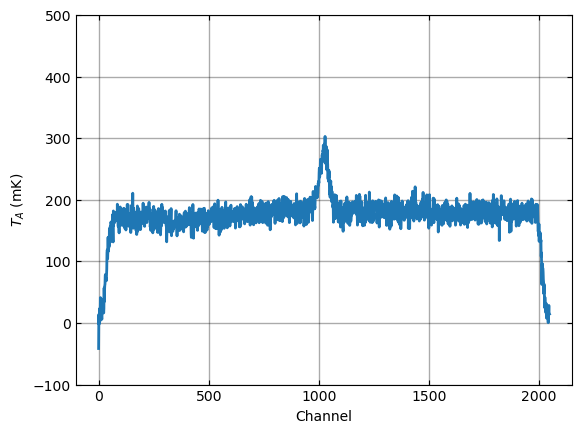

stats: 0.18024204126292784 K 0.011600120304973042 K 1.6157771324860886e-05 K 0.014307348963068595 K 0.8721309095605653


In [10]:
ts1 = ta.smooth('gaussian', 16)
# ts1 = ts1[200:1800]                    # CAVEAT: new feature
ts1.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-100, ymax=500, grid=True)
rolled_stats(ts1.flux[21000//16:28000//16])

### Smoothing more

Now smoothing by 320 channels should result in a noise of 55/sqrt(320) or 3 mK, exacty as measures. The rolled RMS ratio is very close to 1, so neighboring channels are not related. If you would decimate by 160, you would see this ratio drop. Be sure to adjust the range of channels for any new ``rolled_stats()``

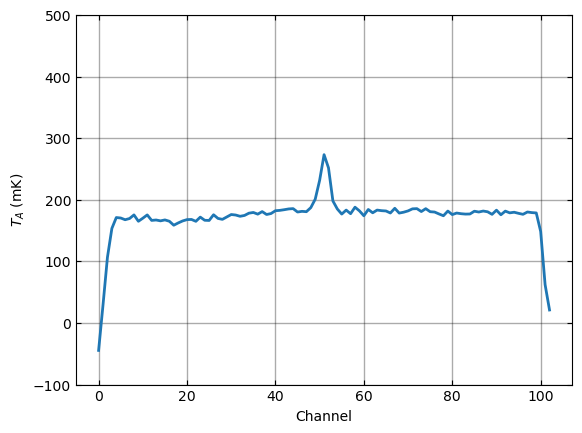

stats: 0.18009006584777243 K 0.003161478029148027 K 0.00011240843538240508 K 0.004397752299407274 K 0.9836160315583877


In [11]:
ts2 = ta.smooth('box', 320)
ts2.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-100, ymax=500, grid=True)
rolled_stats(ts2.flux[60:96])

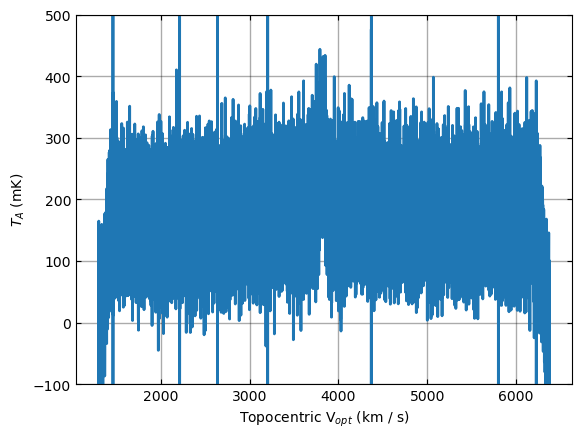

In [12]:
ta.plot(xaxis_unit="km/s", yaxis_unit="mK", ymin=-100, ymax=500)

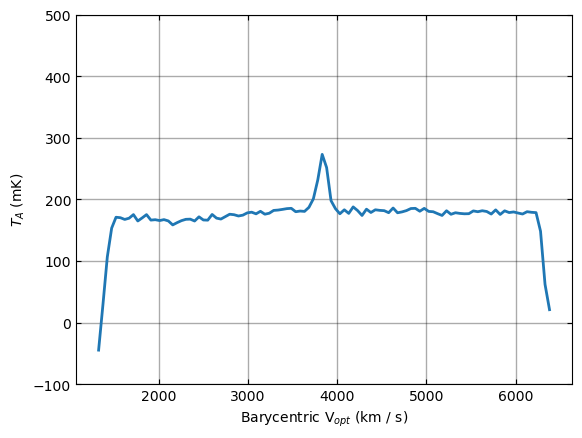

In [13]:
ts2.plot(xaxis_unit="km/s", yaxis_unit="mK", ymin=-100, ymax=500)

# Baseline Subtraction

Given that we are not interested in the edges, we'll define a baseline from say 2000,3500 and 4500,6000 and only plot between 2000 and 6000 km/s

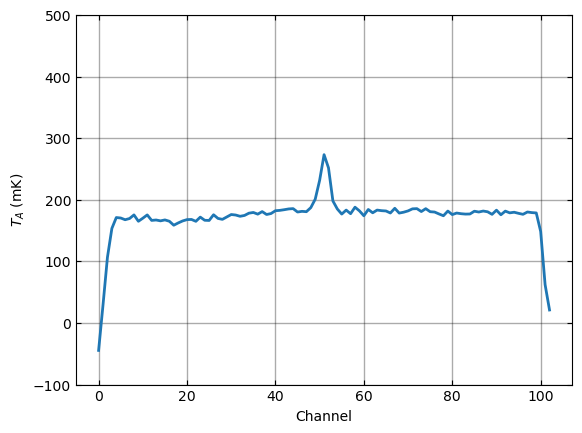

In [14]:
ts2.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-100, ymax=500)

EXCLUDING [Spectral Region, 1 sub-regions:
  (1406894049.2856808 Hz, 1414218268.0356808 Hz) 
, Spectral Region, 1 sub-regions:
  (1401400885.2231808 Hz, 1403231939.9106808 Hz) 
, Spectral Region, 1 sub-regions:
  (1390872320.7700558 Hz, 1397738775.8481808 Hz) 
]


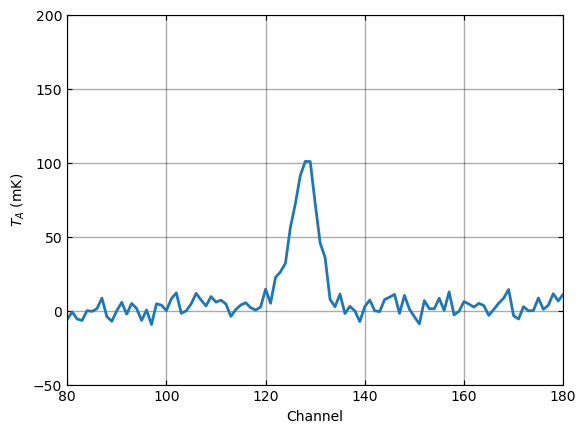

<Polynomial1D(0, c0=0.17844082 K)>

In [15]:
# recompute a very smooth spectrum, gives 256 channels
ts2 = ta.smooth('box', 128)
#
ts2.baseline(degree=0,model="poly",exclude=[(0,80),(120,140),(180,255)], remove=True)
ts2.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-50, ymax=200, grid=True, xmin=80, xmax=180)
ts2.baseline_model

### Output a spectrum

One a Spectrum has been assembled, it can be output into a number of output formats.


In [16]:
# CAVEAT: new feature
ta.write("ngc2415.txt",  format="basic", overwrite=True)
ta.write("ngc2415.fits", format="fits",  overwrite=True)     # SDFITS dialect, ds9 cannot view this
ta.write("ngc2415.ecsv", format="ecsv",  overwrite=True)

## Smoothing the reference ("OFF") scan

Under certain circumstances it can be beneficial to (boxcar) smooth the reference (OFF) signal before the usual
(ON-OFF)/OFF calibration. 

*Technical note*:  if you want to achieve identical results to GBTIDL, the width of the boxcar needs to be odd.


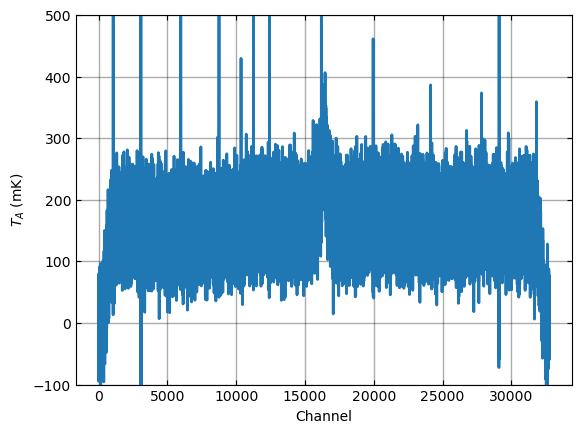

stats: 0.16747795774959787 K 0.039646959701565364 K 9.233633169265177e-06 K 0.054897591120875514 K 0.9791030445859087


In [17]:
sb = sdfits.getps(scan=152, ifnum=0, plnum=0, smoothref=31)
ta = sb.timeaverage(weights='tsys')
ta.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-100, ymax=500, grid=True)
rolled_stats(ta.flux[21000:28000])

We could smooth this spectrum the normal way, as was done a few cells ago, and not much difference is visible, except for the noise level.


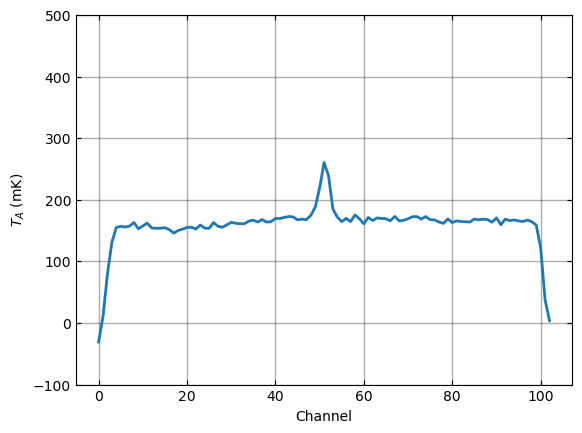

stats: 0.00471483628103625 K 0.04046117679516148 K -0.0005565789383104816 K 0.05214594520907628 K 0.911311889305439


In [18]:
ts2 = ta.smooth('box', 320)
ts2.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-100, ymax=500, grid=True)
rolled_stats(ta.flux[60:95])

Although the RMS has gone down (53 mK to 40 mK), the signal correlation has degraded a small amount from 0.98 to 0.91 due to the added correlation of the reference smoothing.